# Plankton Identifier - Classification from plankton imager

This notebook provides code to run inference on the test-set. It first creates a "dummy-model", after which the trained model is loaded.

# Set up "dummy-model"

## Import modules and set parameters

In [1]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision.all import *

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

print ('You are using FastAI version: ' + fastai.__version__)
# FastAI version in counting paper: 2.0.13

You are using FastAI version: 2.7.13


In [2]:
filename = 'Plankton_imager_v03b' # Insert your filename, for repeated experiments with different trainings hyperparameters (see below)
bs = 600 # Insert highest working batchsize here (limited by hardware)
np.random.seed(3)

## Getting the data

In [3]:
# Get image paths
path = Path('data/OSPAR_merged');
path.ls()

(#12) [Path('data/OSPAR_merged/artefacts'),Path('data/OSPAR_merged/diatoms'),Path('data/OSPAR_merged/detritus'),Path('data/OSPAR_merged/holoplankton'),Path('data/OSPAR_merged/fish_eggs'),Path('data/OSPAR_merged/gelatinous'),Path('data/OSPAR_merged/bubbles'),Path('data/OSPAR_merged/phytoplankton_other'),Path('data/OSPAR_merged/copepods'),Path('data/OSPAR_merged/fish_larvae')...]

In [4]:
fnames = get_image_files(path)
fnames[:3]

(#3) [Path('data/OSPAR_merged/artefacts/pia6.2023-06-01.1110+N00065587.tif'),Path('data/OSPAR_merged/artefacts/pia6.2023-06-01.1110+N00063889.tif'),Path('data/OSPAR_merged/artefacts/pia6.2023-06-13.0550+N00082634.tif')]

## Creating a dataset

In [5]:
# Create dataset


block = DataBlock(blocks=(ImageBlock, CategoryBlock), # for regression, change this CategoryBlock
                  splitter=RandomSplitter(),
                  get_items = get_image_files, 
                  get_y = parent_label,
                  #item_tfms=Resize((770,1040), method='squish'), 
                  item_tfms=Resize(300, ResizeMethod.Pad, pad_mode='zeros'), # see page 73 book
                  batch_tfms=[*aug_transforms( #https://docs.fast.ai/vision.augment#aug_transforms
                      mult=1.0, 
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=0.2,
                      min_zoom=1.0,
                      max_zoom=1.1,
                      max_lighting=0.3,
                      max_warp=0.1,
                      p_affine=0.5,
                      p_lighting=0.5,
                      pad_mode='zeros'), 
                              Normalize.from_stats(*imagenet_stats)] 
                 )

In [6]:
#dls = block.dataloaders(df,bs=bs)
dls = block.dataloaders(path, bs=bs)

## Define model

In [7]:
# met metrics


# Create Learner
learn = vision_learner(dls, resnet50, #loss_func=Huber(), # different ResNets and Loss functions can be specified here
                    metrics=error_rate
                   ); # creates pretrained model
learn.model = torch.nn.DataParallel(learn.model) # Parallels computations over multiplle GPUs

print('This is Plankton Identifier version: ' + filename) # See top
print('The batchsize is set at:', bs) # See top
print('The loss function is:', learn.loss_func) # Double check current loss func

This is Plankton Identifier version: Plankton_imager_v03b
The batchsize is set at: 600
The loss function is: FlattenedLoss of CrossEntropyLoss()


In [8]:
learn.load('Plankton_imager_v03_stage-2_Best')

# Inference

### Set up images for predictions

In [9]:
# Path towards model
#PathModel = Path('data_test');
PathImgs = Path('data/OSPAR_test'); # 



In [10]:
%%time

# Get images to predict
imgs = get_image_files(PathImgs);imgs.sort();imgs

CPU times: user 12.3 ms, sys: 154 µs, total: 12.4 ms
Wall time: 12.4 ms


(#1170) [Path('data/OSPAR_test/pia1.2022-09-25.1750+N00007302.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1750+N00009911.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1800+N00009997.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1820+N00006005.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1820+N00009600.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1840+N00002254.tif'),Path('data/OSPAR_test/pia1.2022-09-25.1840+N00007482.tif'),Path('data/OSPAR_test/pia1.2022-09-25.2150+N00009483.tif'),Path('data/OSPAR_test/pia1.2022-09-25.2310+N00002852.tif'),Path('data/OSPAR_test/pia1.2022-09-25.2350+N00003713.tif')...]

In [11]:
print('The total ammount of images is: ' + str(len(imgs)))
print('The path to the first image is: ' + str(imgs[0]))
print('The path to the last image is: ' + str(imgs[len(imgs)-1]))


The total ammount of images is: 1170
The path to the first image is: data/OSPAR_test/pia1.2022-09-25.1750+N00007302.tif
The path to the last image is: data/OSPAR_test/pia7.2024-08-27.1900+N00062797.tif


In [12]:
# Create image batch for predicting
dl = learn.dls.test_dl(imgs)

### Make predictions

In [13]:
%%time

# Get predictions for image batch (for large dataset (10k images), this takes ~45min)
preds, ignored1, label_numeric = learn.get_preds(dl=dl, with_decoded=True)

CPU times: user 1.16 s, sys: 1.01 s, total: 2.17 s
Wall time: 4.15 s


### Create output

In [14]:
%%time

# Create table (i.e. DataFrame) with predictions
test_df = pd.DataFrame()  # Creates empty table
test_df['Path'] = imgs.items  # Adds paths (including filenames) to table
test_df['Pred'] = label_numeric  # Adds predictions to table

# Change vocab to real class names
class_names = list(learn.dls.vocab)
preds_df = pd.DataFrame(preds, columns=class_names)

# Add predictions to the existing DataFrame
test_df = pd.concat([test_df, preds_df], axis=1)

# Update column 'Pred' with real class names
label_mapping = {i: class_name for i, class_name in enumerate(learn.dls.vocab)}
test_df['Pred'] = test_df['Pred'].map(label_mapping)

# Extract filenames from the full paths in test_df
test_df['Filename'] = test_df['Path'].apply(lambda x: os.path.basename(x))

# Load the ground truth CSV file
ground_truth_file_path = 'data/OSPAR_test.csv'
ground_truth_df = pd.read_csv(ground_truth_file_path)

# Rename 'Subdirectory' column to 'Label'
ground_truth_df.rename(columns={'Subdirectory': 'Label'}, inplace=True)

# Make sure the ground_truth_df also has a 'Filename' column
if 'Filename' not in ground_truth_df.columns:
    ground_truth_df['Filename'] = ground_truth_df['id'].apply(lambda x: os.path.basename(x))

# Merge test_df and ground_truth_df on 'Filename'
merged_df = pd.merge(test_df, ground_truth_df, on='Filename', how='inner')

# Define the desired column order
# Ensure that all the columns are present in merged_df before reordering
desired_order = ['Path', 'Filename', 'Label', 'Pred'] + list(preds_df.columns)

# Ensure that all columns in desired_order exist in merged_df
existing_columns = [col for col in desired_order if col in merged_df.columns]

# Create the Final DataFrame with reordered columns
merged_df = merged_df[existing_columns]

# Export table to .csv file for downstream applications
merged_df.to_csv(filename+'_Preds_test.csv', index=False, float_format='%.9f')

# Calculate and display accuracy
correct_predictions = merged_df['Pred'] == merged_df['Label']
accuracy = correct_predictions.mean()
num_correct_predictions = correct_predictions.sum()

merged_df

CPU times: user 41.6 ms, sys: 8.84 ms, total: 50.4 ms
Wall time: 54.5 ms


,Path,Filename,Label,Pred,artefacts,bubbles,copepods,detritus,diatoms,dinoflagellates,fish_eggs,fish_larvae,gelatinous,holoplankton,meroplankton,phytoplankton_other
0,data/OSPAR_test/pia1.2022-09-25.1750+N00007302.tif,pia1.2022-09-25.1750+N00007302.tif,diatoms,diatoms,2.153129e-10,6.468773e-12,1.125426e-11,3.488235e-04,9.994600e-01,1.910865e-04,5.135985e-12,1.802396e-11,2.757262e-11,1.210828e-08,4.311397e-10,3.199710e-09
1,data/OSPAR_test/pia1.2022-09-25.1750+N00009911.tif,pia1.2022-09-25.1750+N00009911.tif,dinoflagellates,dinoflagellates,1.720869e-07,4.457676e-10,1.610887e-07,1.734805e-03,5.078011e-04,9.977555e-01,2.037821e-08,5.607510e-09,6.298782e-08,1.257129e-06,7.896798e-08,8.066645e-08
2,data/OSPAR_test/pia1.2022-09-25.1800+N00009997.tif,pia1.2022-09-25.1800+N00009997.tif,diatoms,diatoms,4.306492e-05,1.683888e-07,3.441026e-07,1.096224e-02,9.886224e-01,2.867436e-04,2.594993e-08,2.101252e-07,1.285083e-06,7.649526e-05,4.027864e-06,3.098159e-06
3,data/OSPAR_test/pia1.2022-09-25.1820+N00006005.tif,pia1.2022-09-25.1820+N00006005.tif,diatoms,diatoms,1.200354e-10,4.606463e-12,3.461894e-12,5.609927e-07,9.999987e-01,7.366618e-07,2.536620e-11,1.321869e-10,1.805065e-10,7.003356e-10,1.136253e-10,3.064656e-10
4,data/OSPAR_test/pia1.2022-09-25.1820+N00009600.tif,pia1.2022-09-25.1820+N00009600.tif,dinoflagellates,dinoflagellates,3.642864e-23,1.453912e-27,1.609247e-20,5.147632e-18,7.395341e-16,1.000000e+00,1.393900e-19,1.466794e-23,1.414284e-21,5.245521e-24,2.094716e-23,5.822938e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,data/OSPAR_test/pia7.2024-08-27.0400+N00034975.tif,pia7.2024-08-27.0400+N00034975.tif,phytoplankton_other,phytoplankton_other,1.118877e-34,4.727203e-29,1.944028e-34,4.088733e-27,9.475710e-26,4.003962e-28,4.471883e-39,8.247143e-38,7.843531e-29,9.483849e-33,2.239764e-29,1.000000e+00
1066,data/OSPAR_test/pia7.2024-08-27.0800+N00057277.tif,pia7.2024-08-27.0800+N00057277.tif,phytoplankton_other,phytoplankton_other,1.633859e-28,3.747220e-23,2.231590e-24,3.567737e-21,6.925976e-24,4.659098e-23,7.387784e-31,3.382333e-32,5.988728e-22,3.357585e-26,5.223968e-19,1.000000e+00
1067,data/OSPAR_test/pia7.2024-08-27.1200+N00034056.tif,pia7.2024-08-27.1200+N00034056.tif,phytoplankton_other,phytoplankton_other,3.574993e-41,1.126162e-31,7.203767e-40,9.345877e-31,1.092976e-32,1.649047e-32,3.222986e-44,0.000000e+00,6.183586e-32,7.445841e-40,1.768455e-30,1.000000e+00
1068,data/OSPAR_test/pia7.2024-08-27.1900+N00036848.tif,pia7.2024-08-27.1900+N00036848.tif,holoplankton,holoplankton,1.919326e-11,1.704292e-12,1.133139e-09,2.275326e-07,1.680510e-10,1.837594e-09,1.166320e-14,1.287980e-11,2.369827e-10,9.999985e-01,1.286271e-06,2.691240e-11


In [15]:
# Extracting the true labels and predictions
y_true = merged_df['Label']
y_pred = merged_df['Pred']

# Calculate and display metrics
correct_predictions = merged_df['Pred'] == merged_df['Label']
num_correct_predictions = correct_predictions.sum()

# Calculating precision, recall and F1 with 'macro' average
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')

# Printing the results
print(f"Total number of images in test set: {len(merged_df)}")
print(f"Total number of Correct Predictions: {num_correct_predictions}")
print(f"Precision (macro-average): {precision * 100:.2f}%")
print(f"Recall (macro-average): {recall * 100:.2f}%")
print(f"F1 Score (macro-average): {f1 * 100:.2f}%")

Total number of images in test set: 1070
Total number of Correct Predictions: 1023
Precision (macro-average): 95.90%
Recall (macro-average): 95.42%
F1 Score (macro-average): 95.59%


NB. Metrics:
* Precision = True Positives/(True Positives + False Positives)
* Recall = True Positives/(True Positives + False Negatives)
* F1 = 2 * ((Precision * Recall)/(Precision + Recall))

NB. Averaging Methods:

* micro: Calculates metrics globally by counting the total true positives, false negatives, and false positives.
* macro: Calculates metrics for each label, and finds their unweighted average.
* weighted: Calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label).
* None: Returns the metrics for each label.

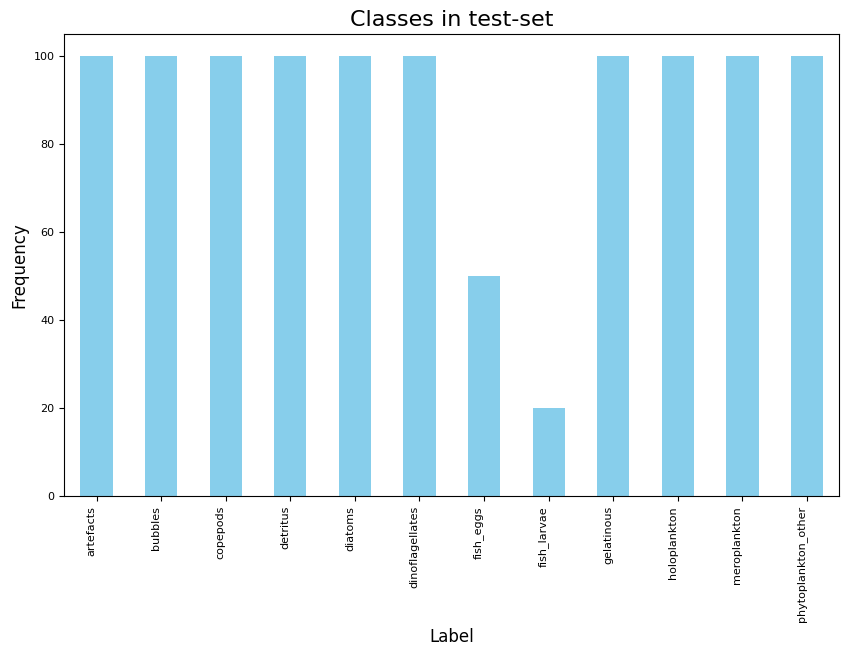

In [16]:
# Ensure the 'Label' column is sorted alphabetically
sorted_labels = merged_df['Label'].sort_values()

# Plot the histogram
plt.figure(figsize=(10, 6))
sorted_labels.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Classes in test-set', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)  # Reduce font size for x-axis labels
plt.yticks(fontsize=8)  # Reduce font size for y-axis labels
plt.show()

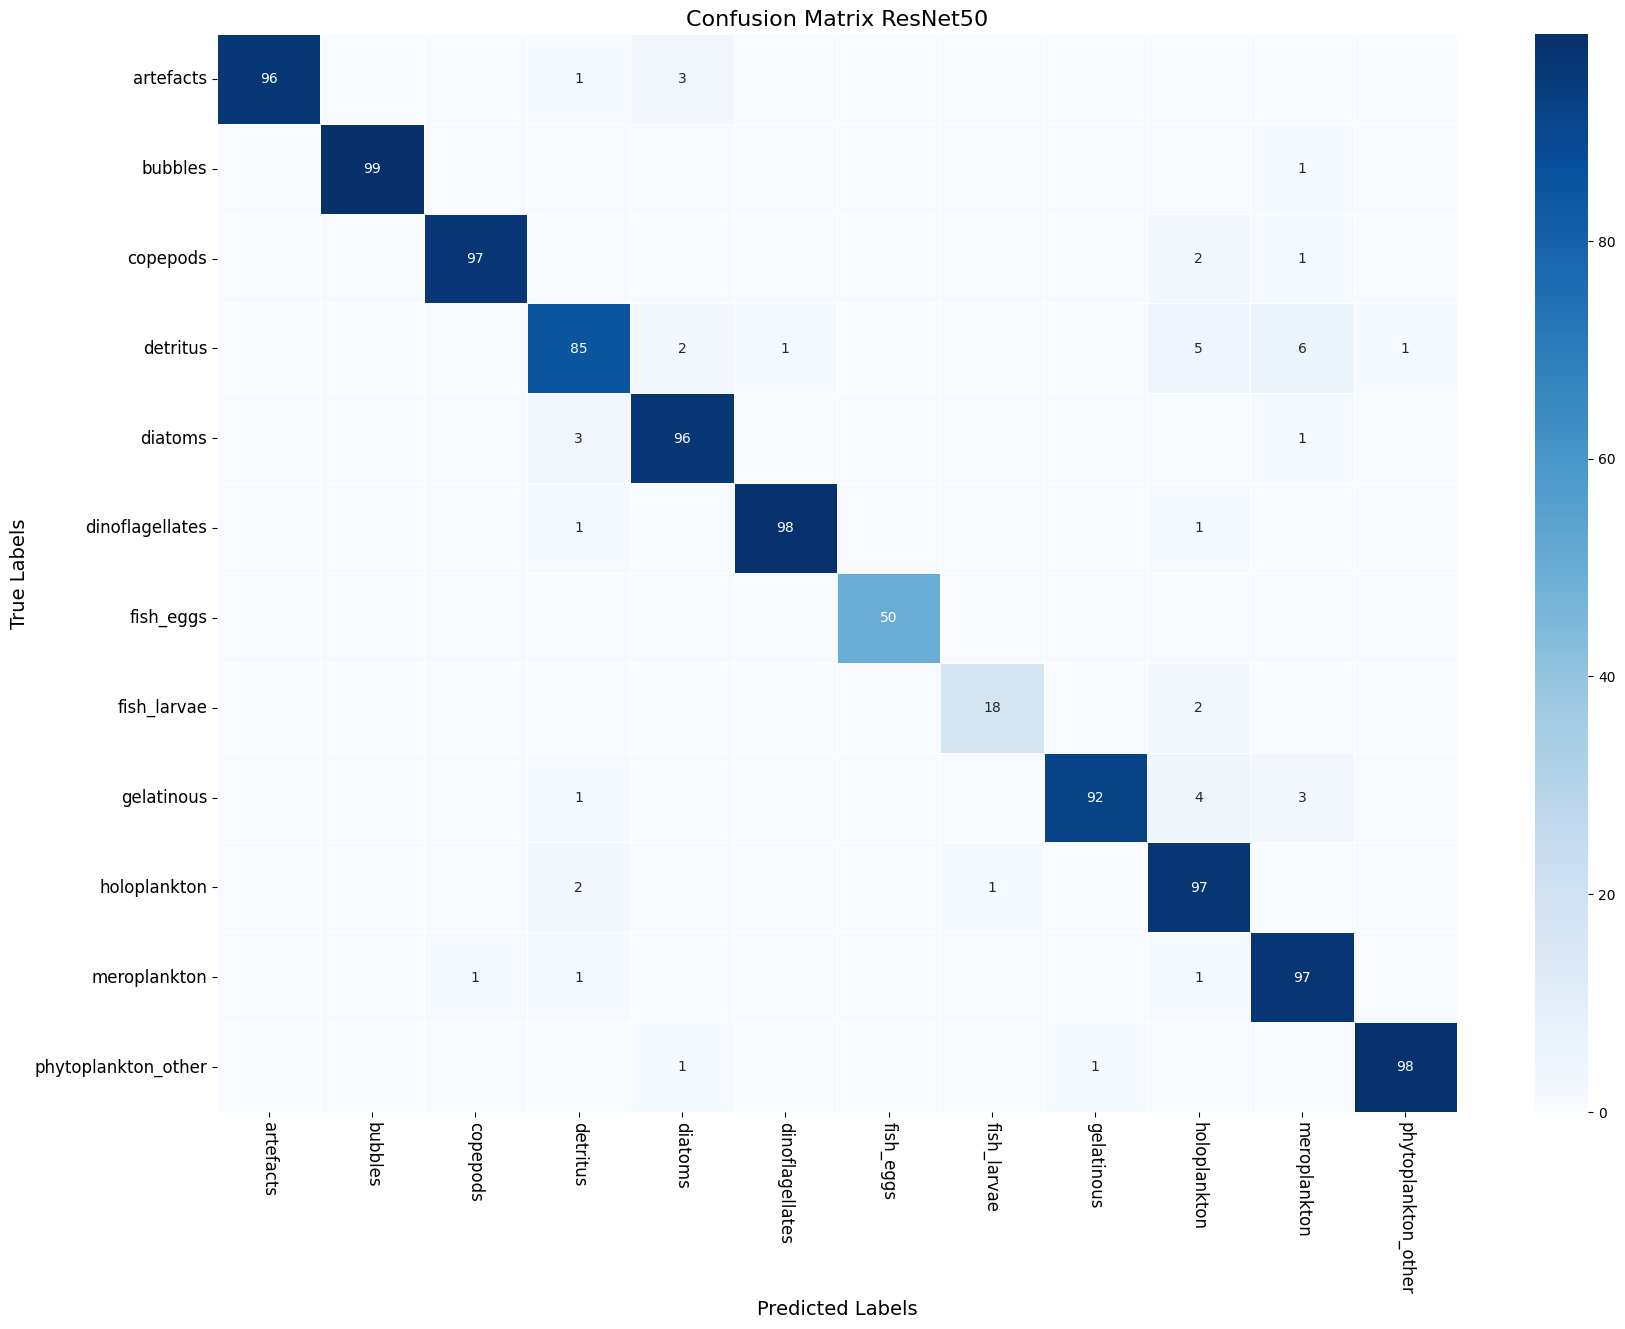

In [17]:
# Define your class labels
class_labels = sorted(merged_df['Label'].unique())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

# Create a custom annotations array where zeroes are replaced with empty strings
annotations = np.where(cm == 0, '', cm)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(20, 14))

sns.heatmap(cm, annot=annotations, fmt='',  # Pass the custom annotations here
            cmap='Blues',
            cbar=True, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            annot_kws={"size": 10},  # Set the font size for annotations
            linewidths=0.5,  # Optional: Add lines between cells for better readability
            linecolor='white'  # Optional: Line color between cells
           )

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix ResNet50', fontsize=16)
plt.xticks(fontsize=12, rotation=-90)
plt.yticks(fontsize=12)

plt.show()


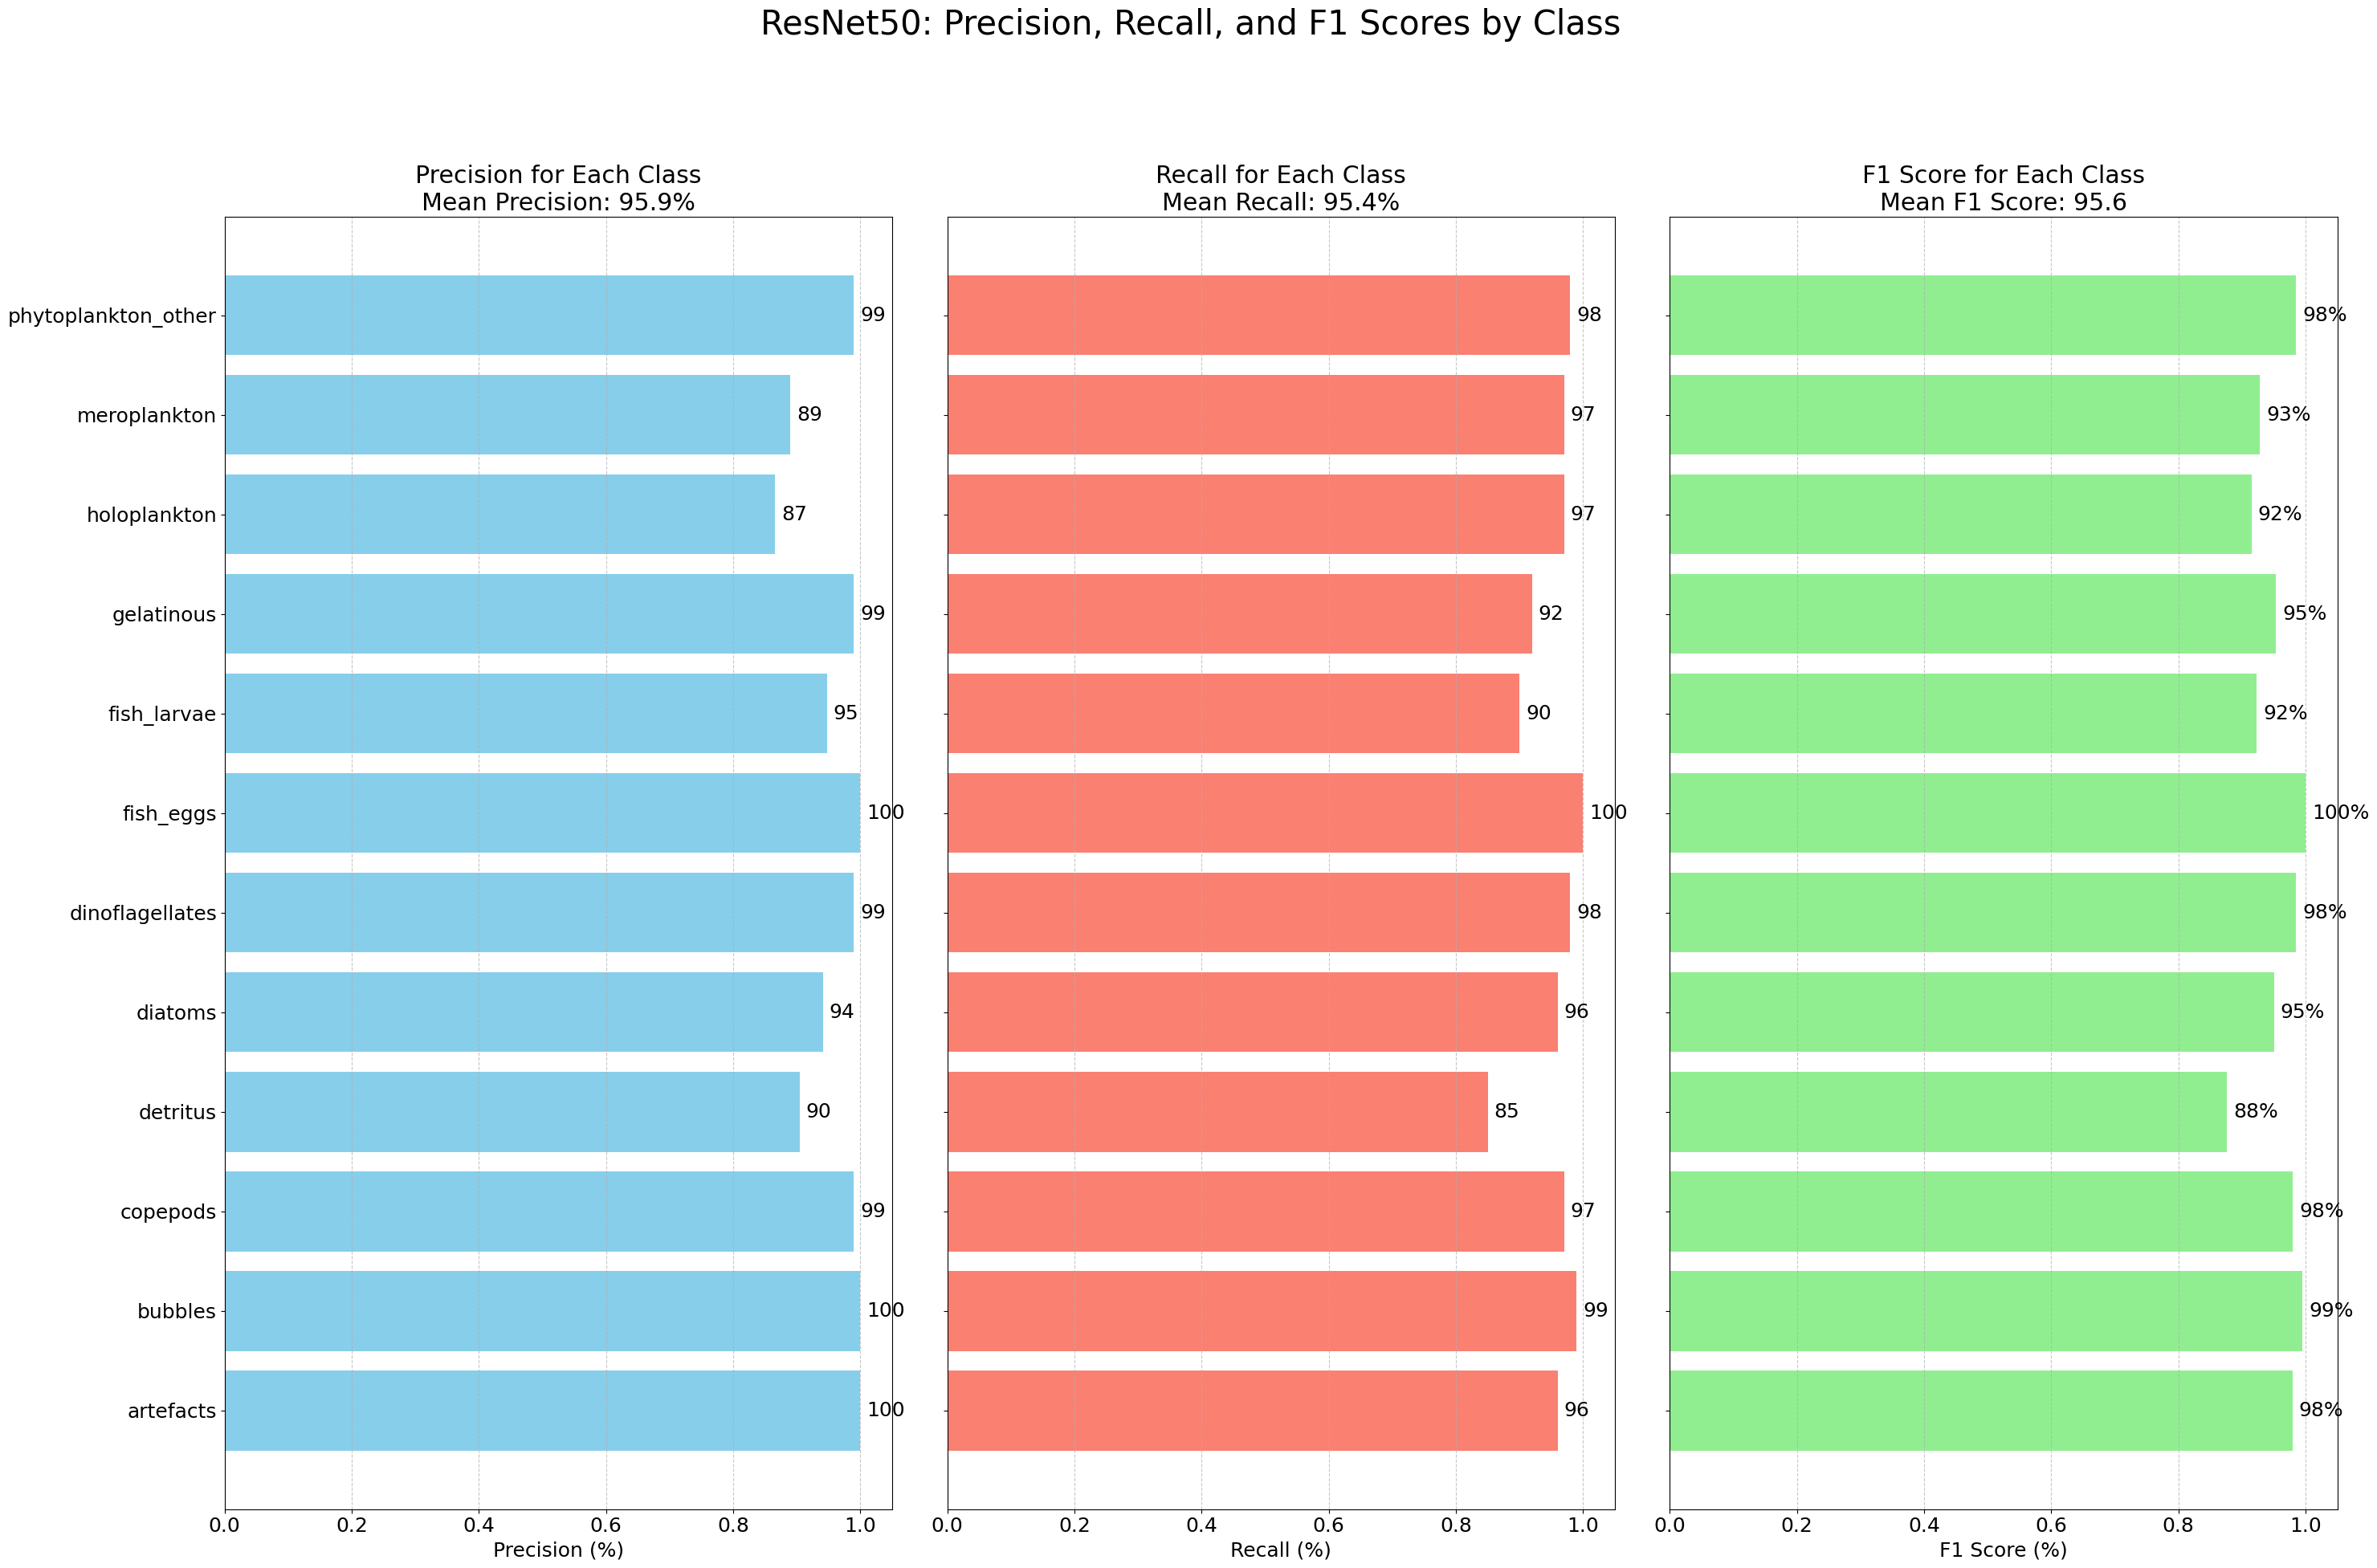

In [18]:
# Font size variable
font_size = 18  # Change this value to adjust font size

# Set global font size
plt.rcParams.update({'font.size': font_size})

# List of unique classes
unique_classes = merged_df['Label'].unique()

# Initialize dictionaries for metrics
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate metrics
for cls in unique_classes:
    # Compute precision, recall, and F1 score for each class
    precision = precision_score(merged_df['Label'], 
                                merged_df['Pred'], labels=[cls], average='macro', zero_division=0)
    recall = recall_score(merged_df['Label'], 
                          merged_df['Pred'], labels=[cls], average='macro', zero_division=0)
    f1 = f1_score(merged_df['Label'], 
                  merged_df['Pred'], labels=[cls], average='macro', zero_division=0)
    precision_scores[cls] = precision
    recall_scores[cls] = recall
    f1_scores[cls] = f1

# Convert to lists for plotting
sorted_classes = sorted(precision_scores.keys())
sorted_precisions = [precision_scores[cls] for cls in sorted_classes]
sorted_recalls = [recall_scores[cls] for cls in sorted_classes]
sorted_f1s = [f1_scores[cls] for cls in sorted_classes]

# Calculate mean values
mean_precision = sum(sorted_precisions) / len(sorted_precisions)
mean_recall = sum(sorted_recalls) / len(sorted_recalls)
mean_f1 = sum(sorted_f1s) / len(sorted_f1s)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(30, 20), sharey=True)

# Plot Precision
axes[0].barh([str(cls) for cls in sorted_classes], sorted_precisions, color='skyblue')
axes[0].set_xlabel('Precision (%)')
axes[0].set_title(f'Precision for Each Class\nMean Precision: {mean_precision*100:.1f}%')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the precision panel
for i, cls in enumerate(sorted_classes):
    axes[0].text(sorted_precisions[i] + 0.01, i, f'{sorted_precisions[i]*100:.0f}', va='center', ha='left')

# Plot Recall
axes[1].barh([str(cls) for cls in sorted_classes], sorted_recalls, color='salmon')
axes[1].set_xlabel('Recall (%)')
axes[1].set_title(f'Recall for Each Class\nMean Recall: {mean_recall*100:.1f}%')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the recall panel
for i, cls in enumerate(sorted_classes):
    axes[1].text(sorted_recalls[i] + 0.01, i, f'{sorted_recalls[i]*100:.0f}', va='center', ha='left')

# Plot F1 Score
axes[2].barh([str(cls) for cls in sorted_classes], sorted_f1s, color='lightgreen')
axes[2].set_xlabel('F1 Score (%)')
axes[2].set_title(f'F1 Score for Each Class\nMean F1 Score: {mean_f1*100:.1f}')
axes[2].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the F1 score panel
for i, cls in enumerate(sorted_classes):
    axes[2].text(sorted_f1s[i] + 0.01, i, f'{sorted_f1s[i]*100:.0f}%', va='center', ha='left')

plt.suptitle('ResNet50: Precision, Recall, and F1 Scores by Class', fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make space for suptitle
plt.show()


In [ ]:
# Some CUDA/GPU tests

def check_all_cuda_devices():
    device_count = torch.cuda.device_count()
    for i in range(device_count):
        print('>>>> torch.cuda.device({})'.format(i))
        result = torch.cuda.device(i)
        print(result, '\n')

        print('>>>> torch.cuda.get_device_name({})'.format(i))
        result = torch.cuda.get_device_name(i)
        print(result, '\n')


def check_cuda():
    print('>>>> torch.cuda.is_available()')
    result = torch.cuda.is_available()
    print(result, '\n')

    print('>>>> torch.cuda.device_count()')
    result = torch.cuda.device_count()
    print(result, '\n')

    print('>>>> torch.cuda.current_device()')
    result = torch.cuda.current_device()
    print(result, '\n')

    print('>>>> torch.cuda.device(0)')
    result = torch.cuda.device(0)
    print(result, '\n')

    print('>>>> torch.cuda.get_device_name(0)')
    result = torch.cuda.get_device_name(0)
    print(result, '\n')

    check_all_cuda_devices()


def check_cuda_ops():
    print('>>>> torch.zeros(2, 3)')
    zeros = torch.zeros(2, 3)
    print(zeros, '\n')

    print('>>>> torch.zeros(2, 3).cuda()')
    cuda_zero = torch.zeros(2, 3).cuda()
    print(cuda_zero, '\n')

    print('>>>> torch.tensor([[1, 2, 3], [4, 5, 6]])')
    tensor_a = torch.tensor([[1, 2, 3], [4, 5, 6]]).cuda()
    print(tensor_a, '\n')

    print('>>>> tensor_a + cuda_zero')
    sum = tensor_a + cuda_zero
    print(sum, '\n')

    print('>>>> tensor_a * cuda_twos')
    tensor_a = tensor_a.to(torch.float)
    cuda_zero = cuda_zero.to(torch.float)
    cuda_twos = (cuda_zero + 1.0) * 2.0
    product = tensor_a * cuda_twos
    print(product, '\n')

    print('>>>> torch.matmul(tensor_a, cuda_twos.T)')
    mat_mul = torch.matmul(tensor_a, cuda_twos.T)
    print(mat_mul, '\n')

try:
    check_all_cuda_devices()
except Exception as e:
    print('get_version() failed, exception message below:')
    print(e)

try:
    check_cuda()
except Exception as e:
    print('check_cuda() failed, exception message below:')
    print(e)

try:
    check_cuda_ops()
except Exception as e:
    print('check_cuda_ops() failed, exception message below:')
    print(e)